In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import time
import torch.utils.data
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import pandas as pd
from models import *


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])


In [2]:


# Function to load a batch file and return a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load dataset, combine batches, split, and visualize images
def load_and_prepare_data():
    # Load and combine the training batches
    data_batches, label_batches = [], []
    for i in range(1, 6):
        batch = unpickle(f'data/KaggleData/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
        data_batches.append(batch[b'data'])
        label_batches.append(batch[b'labels'])
    X, y = np.concatenate(data_batches), np.concatenate(label_batches)
    
    # Split into training and validation sets (80-20 split)
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = load_and_prepare_data()

# Define transformations
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformations = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(), 
        transforms.RandomApply([transforms.RandomErasing()], p=0.5),
        transforms.Normalize(*stats)]),
        
    'valid': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)]),
        
    # Normalization only for 'train_Default' scenario
    'normalization_only': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)])
}

# Adjusting the CIFAR10Dataset class initialization to accept 'data_mode'
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None, data_mode='default'):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.data_mode = data_mode
        if data_mode == 'train_Enhanced':
            self.data = np.concatenate((self.data, self.data), axis=0)
            self.labels = np.concatenate((self.labels, self.labels), axis=0)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.data_mode == 'train_Enhanced' and idx >= len(self.labels) // 2: #half the data gets copied, then transformed with train transformer
            transform = transformations['train']
        else:
            transform = self.transform
        image = self.data[idx % len(self.labels)].reshape(3, 32, 32).transpose(1, 2, 0)
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        image = transform(image)
        return image, self.labels[idx % len(self.labels)]

# Create datasets and DataLoader instances
datasets = {
    'train_Default': CIFAR10Dataset(X_train, y_train, transform=transformations['normalization_only']),
    'train_Altered': CIFAR10Dataset(X_train, y_train, transform=transformations['train']),
    'train_Enhanced': CIFAR10Dataset(X_train, y_train, transform=transformations['normalization_only'], data_mode='train_Enhanced'),
    'valid': CIFAR10Dataset(X_val, y_val, transform=transformations['valid'])
}

# Update loaders for each dataset
loaders = {
    'train_Default': DataLoader(datasets['train_Default'], batch_size=64, shuffle=True),
    'train_Altered': DataLoader(datasets['train_Altered'], batch_size=64, shuffle=True),
    'train_Enhanced': DataLoader(datasets['train_Enhanced'], batch_size=64, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=64, shuffle=False)
}

print('Amount of Train Data batches (Default):', len(loaders['train_Default']))
print('Amount of Train Data batches (Altered):', len(loaders['train_Altered']))
print('Amount of Train Data batches (Enhanced):', len(loaders['train_Enhanced']))
print('Amount of Valid Data batches:', len(loaders['valid']))

print('Amount of training images (Original and Altered):', len(X_train))
print('Amount of training images (Enhanced):', len(datasets['train_Enhanced']))
print('Amount of Validation images:', len(X_val))


Amount of Train Data batches (Default): 625
Amount of Train Data batches (Altered): 625
Amount of Train Data batches (Enhanced): 1250
Amount of Valid Data batches: 157
Amount of training images (Original and Altered): 40000
Amount of training images (Enhanced): 80000
Amount of Validation images: 10000


# Model Setup

In [3]:
def Resnet3_443():
    return ResNet3(BasicBlock, [4,4,3])

modelResnet3_443 = Resnet3_443()

total_paramsResnet3_443 = sum(p.numel() for p in modelResnet3_443.parameters())
print(f"Total parameters modelResnet3_443: {total_paramsResnet3_443}")

# Move the model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

modelResnet3_443.to(device)


Total parameters modelResnet3_443: 4697162
NVIDIA GeForce RTX 4070


ResNet3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Training Method

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import time

def train_and_evaluate_model(model, model_name, loaders, device, loader_key, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
    scheduler = ExponentialLR(optimizer, gamma=0.98)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders[loader_key]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item()
            num_batches += 1

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            num_train_examples += labels.size(0)

            if (i + 1) % 100 == 0 or i == len(loaders[loader_key]) - 1:
                print(f"{model_name}, {loader_key} - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders[loader_key].dataset)} "
                      f"({100. * (i + 1) / len(loaders[loader_key]):.0f}%)]  Loss: {running_loss / max(1, num_batches):.4f}")
                running_loss, num_batches = 0.0, 0

        avg_train_loss = total_train_loss / num_train_examples
        train_loss_history.append(avg_train_loss)

        # Calculate and append training accuracy for the epoch
        train_accuracy = 100. * total_correct_train / num_train_examples
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss, total_correct_valid = 0.0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() +inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_correct_valid += (predicted == labels).sum().item()

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)
        valid_loss_history.append(avg_valid_loss)
        
        valid_accuracy = 100. * total_correct_valid / len(loaders['valid'].dataset)
        valid_accuracy_history.append(valid_accuracy)

        print(f"{model_name}, {loader_key} - Epoch {epoch}: Avg. Training Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), f'{model_name}_{loader_key}_best_model.pth')
            print(f"Saved best model for {model_name} with {loader_key} at epoch {epoch}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"{model_name} with {loader_key} - Execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history, scheduler.get_last_lr()[0]


# Training

Total parameters in modelResnet3_443: 4697162
NVIDIA GeForce RTX 4070
Resnet3_443, train_Default - Epoch: 1 [6400/40000 (16%)]  Loss: 1.8489
Resnet3_443, train_Default - Epoch: 1 [12800/40000 (32%)]  Loss: 1.6184
Resnet3_443, train_Default - Epoch: 1 [19200/40000 (48%)]  Loss: 1.4824
Resnet3_443, train_Default - Epoch: 1 [25600/40000 (64%)]  Loss: 1.3671
Resnet3_443, train_Default - Epoch: 1 [32000/40000 (80%)]  Loss: 1.2524
Resnet3_443, train_Default - Epoch: 1 [38400/40000 (96%)]  Loss: 1.1780
Resnet3_443, train_Default - Epoch: 1 [40000/40000 (100%)]  Loss: 1.1057
Resnet3_443, train_Default - Epoch 1: Avg. Training Loss: 0.0226, Train Accuracy: 46.44%, Avg. Valid Loss: 0.0190, Valid Accuracy: 57.49%
Saved best model for Resnet3_443 with train_Default at epoch 1
Resnet3_443, train_Default - Epoch: 2 [6400/40000 (16%)]  Loss: 1.0852
Resnet3_443, train_Default - Epoch: 2 [12800/40000 (32%)]  Loss: 1.0247
Resnet3_443, train_Default - Epoch: 2 [19200/40000 (48%)]  Loss: 0.9810
Resnet3_44

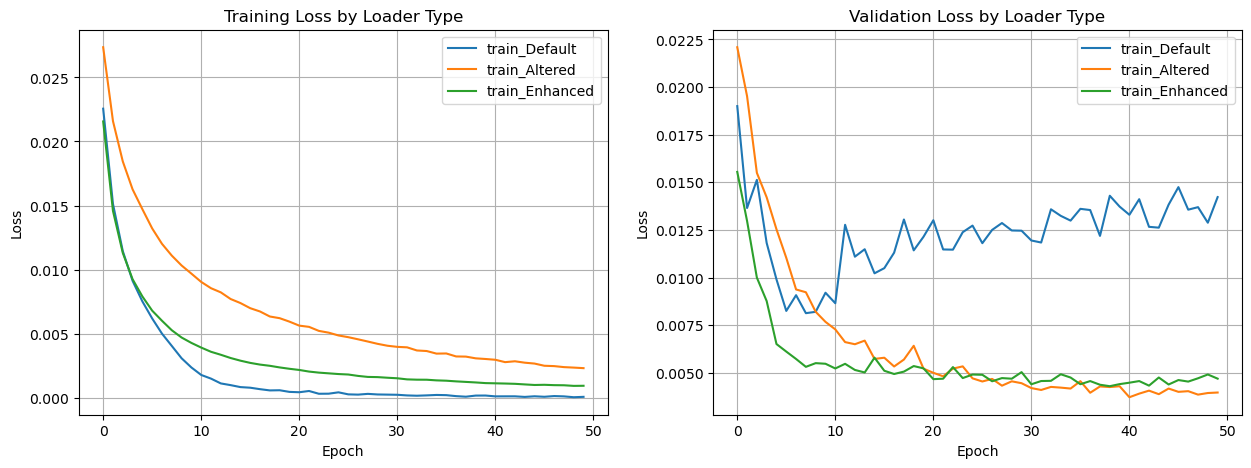

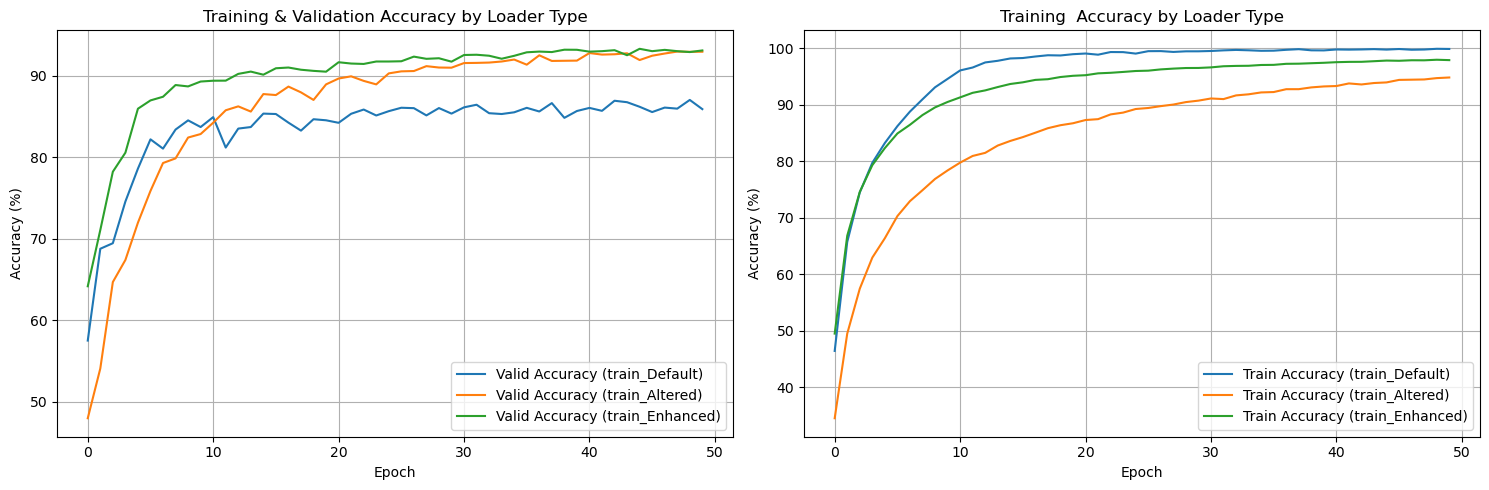

In [5]:
import torch
import matplotlib.pyplot as plt

modelResnet3_443 = Resnet3_443().to(device)
print(f"Total parameters in modelResnet3_443: {sum(p.numel() for p in modelResnet3_443.parameters())}")
print(torch.cuda.get_device_name(0))

# Initialize dictionaries to store the metrics for different dataset types
all_metrics = {
    'train_Default': {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': [], 'last_lr': None},
    'train_Altered': {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': [], 'last_lr': None},
    'train_Enhanced': {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': [], 'last_lr': None}
}

loader_keys = ['train_Default', 'train_Altered', 'train_Enhanced']
model_name = 'Resnet3_443'

# Train and evaluate the model with each dataset type
for loader_key in loader_keys:
    # Ensure model is reset or reinitialized here if necessary
    modelResnet3_443 = Resnet3_443().to(device)  # Reinitialize if you want a fresh start for each training phase
    
    train_loss, valid_loss, valid_accuracy, train_accuracy, last_lr = train_and_evaluate_model(modelResnet3_443, model_name, loaders, device, loader_key, num_epochs=50)
    
    # Storing the metrics
    metrics = all_metrics[loader_key]
    metrics['train_losses'] = train_loss
    metrics['valid_losses'] = valid_loss
    metrics['valid_accuracies'] = valid_accuracy
    metrics['train_accuracies'] = train_accuracy  # Assuming this modification
    metrics['last_lr'] = last_lr


# Now, let's adjust the plotting section to compare across loaders
plt.figure(figsize=(15, 5))

# Training Loss Across Different Loaders
plt.subplot(1, 2, 1)
for loader_key, metrics in all_metrics.items():
    plt.plot(metrics['train_losses'], label=f'{loader_key}')
plt.title('Training Loss by Loader Type')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Validation Loss Across Different Loaders
plt.subplot(1, 2, 2)
for loader_key, metrics in all_metrics.items():
    plt.plot(metrics['valid_losses'], label=f'{loader_key}')
plt.title('Validation Loss by Loader Type')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.figure(figsize=(15, 5))

# Combined Training and Validation Accuracy
plt.subplot(1, 2, 1)
for loader_key, metrics in all_metrics.items():
    plt.plot(metrics['valid_accuracies'], label=f'Valid Accuracy ({loader_key})')
plt.title('Training & Validation Accuracy by Training Data Loader Type')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Combined Training and Validation Accuracy
plt.subplot(1, 2, 2)
for loader_key, metrics in all_metrics.items():
    plt.plot(metrics['train_accuracies'], label=f'Train Accuracy ({loader_key})')
plt.title('Training  Accuracy by Loader Type')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()
